In [0]:
#Unzip the uploaded data into Google Drive
#!unzip "drive/My Drive/Colab Notebooks/Data/dog-vision-data/dog-breed-identification (1).zip" -d "drive/My Drive/Colab Notebooks/Data/dog-vision-data"

# End-to-end Multi-class Dog Bread classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the bread of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, want to know breed of dog it is.

https://www.kaggle.com/c/dog-breed-identification/data

## 2. Data

The data we're using is from kaggle's dog bread identification competition.

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Featues

some information about the data:
  * we're dealing with images (Unstructured data) so it's probably best we use deep learning/transfer learning.
  * There are 120 breeds of dogs(this means there are 120 different classes)
  * There are around 10,000+ images in the test set(these images have no labels, because we'll want to predict them).

## Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [1]:
#Import TensorFlow into Colab
import tensorflow as tf
print("TF version", tf.__version__)

TF version 2.2.0-rc3


In [0]:
#Import TensorFlow Hub
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)

TF Hub version: 0.8.0


In [0]:
#Check for GPU availability
print("GPU","available (YESSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available:")

GPU available (YESSS!!!!)


## Getting out data ready(turning into Tensors)

With all machine learning models, our data has to be in numerical format.So that's what we'll be doing first.Turning our images into Tensors

In [0]:
 #Check out labels of our data
 import pandas as pd
 labels_csv  = pd.read_csv("drive/My Drive/Colab Notebooks/Data/dog-vision-data/labels.csv")
 print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     14a44cf4253e82340f83293e3920af11  scottish_deerhound
freq                                   1                 126


In [0]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [0]:
#How many images are there of each bread?
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

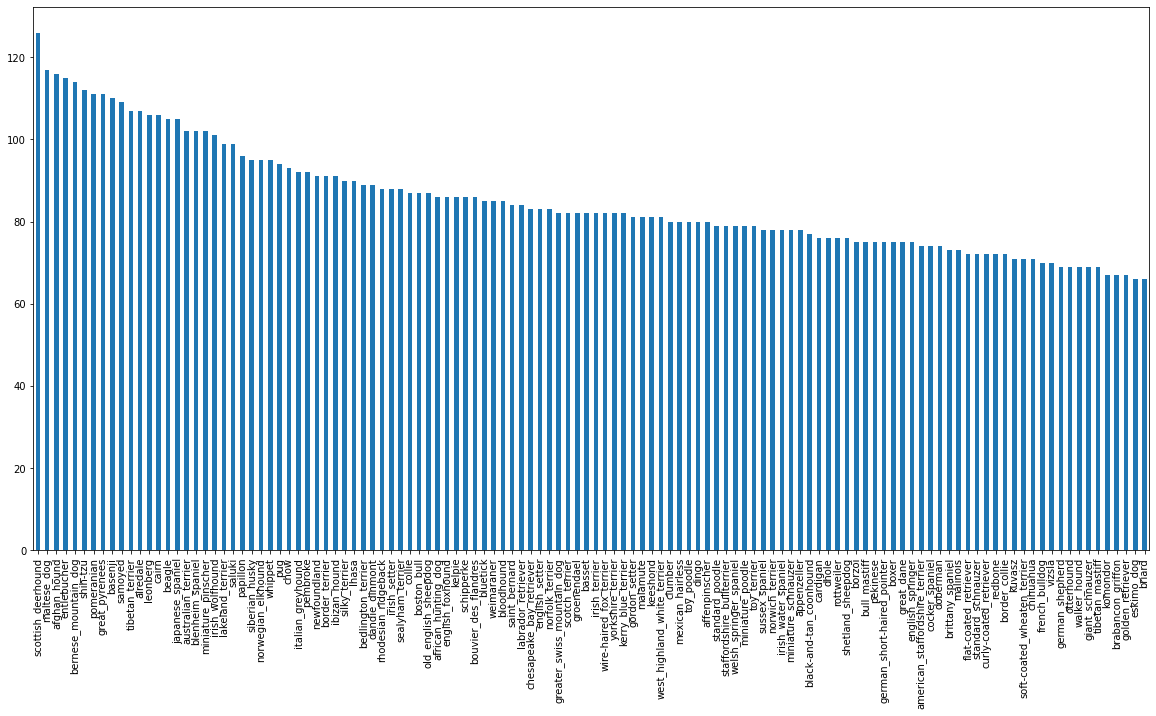

In [0]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

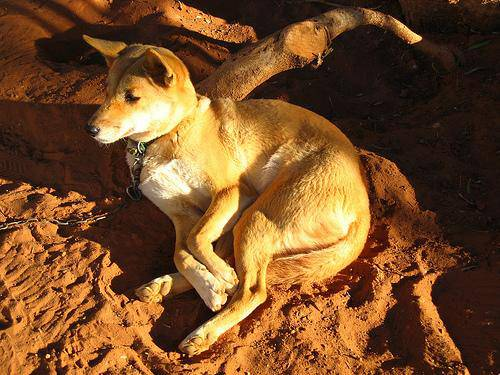

In [0]:
#Let's view a image
from IPython.display import Image
Image("drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames

In [0]:
#Create pathname for image ID's
filenames = ["drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/"+fname+".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [0]:
#Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Colab Notebooks/Data/dog-vision-data/train")) == len(filenames):
  print("Filenames match actual of files")

else:
  print("Filenames do not match actual amount of file, check the target directory")

Filenames match actual of files


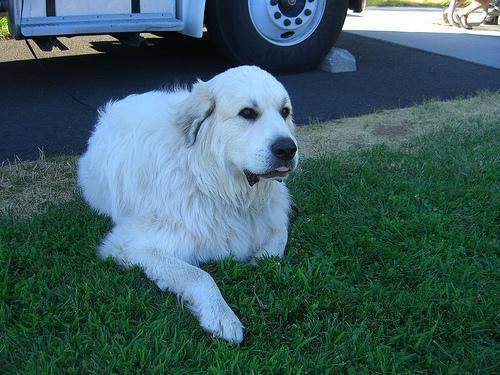

In [0]:
Image(filenames[3001])

In [0]:
labels_csv["breed"][3001]

'great_pyrenees'

Sine we've now got our training image filepaths in a list.Let's prepare our labels

In [0]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) #Does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [0]:
#See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames


In [0]:
#Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [0]:
#Turn every label into a boolean array
boolean_labels = [unique_breeds == label for label in labels] 
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [0]:
len(boolean_labels)

10222

In [0]:
#Example Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) #index where label occur
print(boolean_labels[0].argmax()) #index where label occur in boolean array
print(boolean_labels[0].astype(int))#there will be a 1 where the sample label occur

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [0]:
# Setup X & Y variables
x = filenames
y = boolean_labels

In [0]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and increases as needed.

In [0]:
#Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [0]:
# Let's split our data into train and validation sets
from sklearn.model_selection import  train_test_split

#Split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                    y[:NUM_IMAGES],
                                                    test_size=0.2,
                                                    random_state=42)

len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

In [0]:
#Let's have a geez at the training data
x_train[:2], y_train[:2]

(['drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Colab Notebooks/Data/dog-vision-data/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
       

##  Preprocessing Images (Turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things.

1. Take an images filepath as input
2. Use TensorFlow to read and save it to a variable, image.
3. Turn our image (a jpg into Tensors)
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the image to be a shape of (224,224)
6. Return the modified image


Before we do, let's see what importing an image looks like.


In [0]:
#Convert image into Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape
#(Height, Width, Color_Channel)
#Color_Channel --> Red/Green/Blue

(257, 350, 3)

In [0]:
image.max(), image.min()

(255, 0)

In [0]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [0]:
#Turn image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

####TensorFlow object and numpy array image has same shape, but difference is tensorflow object we can run by using GPU 


In [0]:
#Define image size
IMG_SIZE = 224

#Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """
  #Read in an image file
  image = tf.io.read_file(image_path)
 
  #Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  #Convert the colour channel values from 0-255 to 0-1 values
  #Normalize the image colour
  image = tf.image.convert_image_dtype(image, tf.float32)

  #Resize the image to our desired value (244, 244)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image


## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go...they all might not fit into memory.

So that's why we do about 32(this is the batch size)images at a time(you can manually adjust the batch size if need be.)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label).`

In [0]:
#Create a simple function  to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label.
  Processes the image and returns a typle of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [0]:
#Demo of the above
process_image(x[42]), tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)` , let's make a function to turn all of our data (X & Y) into batches!

In [0]:
#Define the batch size, 32 is a good start
BATCH_SIZE = 32

#Create a function to turn data into batches
def create_data_batches(X, Y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels)
  """

  #If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #Only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                            tf.constant(Y))) #labels

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    #Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(Y)))
    
    #Shuffling pathnames and labels before mapping image processors function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))
    
    #Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label) 

    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch


In [0]:
#Creating training and validation data batches
train_data = create_data_batches(x_train, y_train)
valid_data = create_data_batches(x_val, y_val, valid_data=True)


Creating training data batches...
Creating validation data batches...


In [0]:
#Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec
#shape = (Batch-->value is 32 , height, width , color_channel)

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

our data is now in batches, however , these can be a little hard to understand/comprehend, let's visualize the data

In [0]:
 import matplotlib.pyplot as plt

#Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays plot of 25 images and their labels from a data batch
  """

  #Setup the figure
  plt.figure(figsize=(10,10))
  #Loop through 25 (for displaying 25 images)
  for i in range(25):
    #Create subplots (5 rows , 5 columns)
    ax = plt.subplot(5,5,i+1)
    #Display an image
    plt.imshow(images[i])
    #Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    #Turn the grid lines off
    plt.axis("off")

In [0]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)
#32 is because batch size is 32

(32, 32)

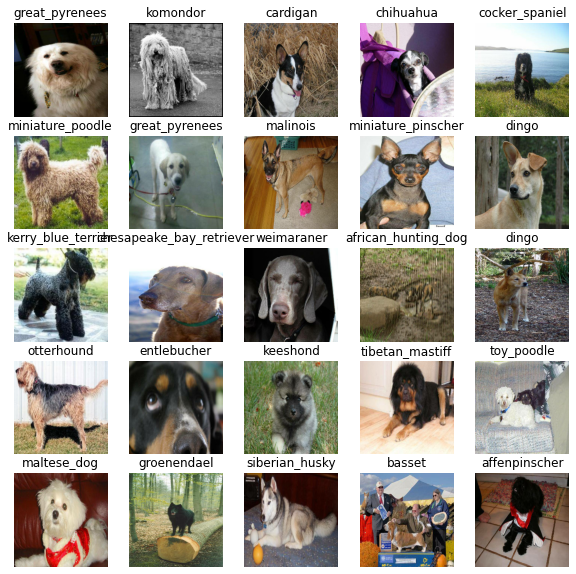

In [0]:
#Now let's visualize the data in a trianing btch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

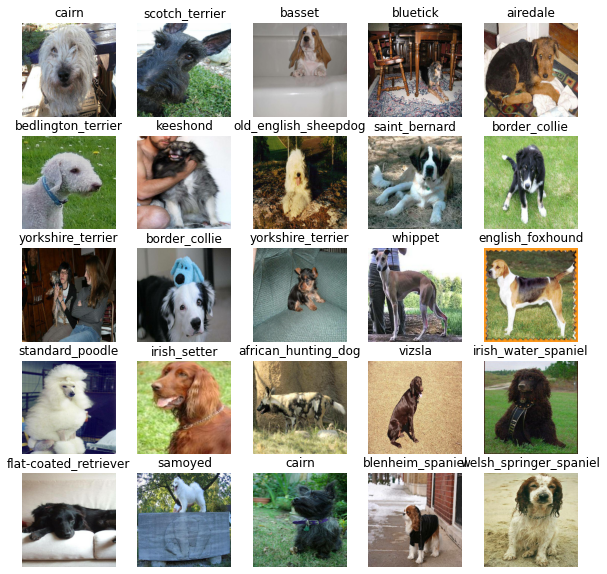

In [0]:
 #Now let's visualize our validation set
 val_images, val_labels = next(valid_data.as_numpy_iterator())
 show_25_images(val_images, val_labels)

 ## Building a model

 Before we build a model there are a few thing we need to define:
 * The input shape(our images shape, in the form of Tensors) to our model.
 *The output shape(image labels, in the form of Tensors) of our model.
 *The URL of the model we want to use from Tensorflow hub https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
#Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #Batch, height ,width, colour channels

#Setup output shape of out model
OUTPUT_SHAPE = len(unique_breeds)

#Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"



Now we've got our inputs, outputs and model ready to go.Let's put them together into a Keras deep learning model!

Knowing this, let's create function which:                              
  * Takes the input shape, output shape and the model we've chosen as parameters.              
  * Defines the layers in a Keras model in sequential fashion(do this first ,  then this, then that)                             
  * Compiles the model (says it should be evaluated and improved).       
  * Builds the model(tells the model the input shape it'll be getting).   
  * Returns the model.
All these steps can be found here : https://www.tensorflow.org/guide/keras/overview


In [0]:
#Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with :", MODEL_URL)

  #Setup the model layers
  model = tf.keras.Sequential([
                hub.KerasLayer(MODEL_URL), #Layer 1 (input layer)
                tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                      activation="softmax")#Layer 2 (Output layer)
  ])

  #Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  #Build the model
  model.build(INPUT_SHAPE)

  return model

In [0]:
model = create_model()
model.summary()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [0]:
INPUT_SHAPE

[None, 224, 224, 3]

In [0]:
OUTPUT_SHAPE

120

## Creating callbacks

Callbacks are helper function a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

we'll create two callbaks , one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

## TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
  1. Load the TensorBoard notebook extension
  2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
  3. Visualize our models training logs with `%tensorboard` magic function (we'll do this after model training).

In [0]:
#Load TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

#Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  #Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Colab Notebooks/Data/dog-vision-data/logs",
                        #Make it so the logs get trained whenever the we run an experimentation
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

## Early Stooping Callback

Early stopping helps our model from overfitting by stoping training if a certain evaluation metric stops                                 
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [0]:
 #Create early stooping callback
 early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                   patience=3)

## Training a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100#@param {type:"slider", min:10, max:100, step:10}

In [0]:
#Check to make sure we're still running on a gpu
print("GPU","available (YES !!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (YES !!!!)


Let's create a function which trains a model.
* Create a model using create_model()
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
*Return the model

In [0]:
#Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """

  #Create a model
  model = create_model()

  #Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  #Fit the model to the data passing it the callbacks we created 
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  #Fit the fitted model
  return model

In [0]:
#Fit the model to the data
model = train_model()

#Train the 25 steps
# train_image = 800
# badge_size = 32
# steps = 800/32 = 25

#loss --> we should miimize the loss value
#accuracy --> we should maximize the accuracy

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 686s 27s/step - loss: 4.6092 - accuracy: 0.1100 - val_loss: 3.6057 - val_accuracy: 0.1850
Epoch 2/100
25/25 [==============================] - 6s 237ms/step - loss: 1.6668 - accuracy: 0.6800 - val_loss: 2.2831 - val_accuracy: 0.4600
Epoch 3/100
25/25 [==============================] - 6s 239ms/step - loss: 0.5741 - accuracy: 0.9375 - val_loss: 1.7811 - val_accuracy: 0.5500
Epoch 4/100
25/25 [==============================] - 6s 239ms/step - loss: 0.2563 - accuracy: 0.9875 - val_loss: 1.5525 - val_accuracy: 0.6000
Epoch 5/100
25/25 [==============================] - 6s 239ms/step - loss: 0.1490 - accuracy: 0.9962 - val_loss: 1.4514 - val_accuracy: 0.6150
Epoch 6/100
25/25 [==============================] - 6s 237ms/step - loss: 0.0997 - accuracy: 1.0000 - val_loss: 1.4006 - val_accuracy: 0.6350
Epoch 7/100
25/25 [=============================

**Question** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in the deep learning neural networks?

**Note** Overfitting to begin with is a good thing! It means our model is learning?

## Checking the TensorBoard logs

The TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and visualize its contents.

In [0]:
%tensorboard --logdir drive/My\ Drive/Colab\ Notebooks/Data/dog-vision-data/logs

#/content/drive/My Drive/Colab Notebooks/Data/dog-vision-data/logs

Output hidden; open in https://colab.research.google.com to view.

## Making and evaluating predictions using a trained model

In [0]:
#Make predictions on the validation data (not used to train on)
predictions = model.predict(valid_data, verbose=1)
predictions

#verbose --> when you do predictions show me your progress

7/7 [==============================] - 1s 152ms/step


array([[1.1690194e-03, 5.5139390e-05, 2.0725790e-03, ..., 1.2555065e-03,
        8.0927966e-06, 5.9130718e-04],
       [2.6079009e-03, 6.3642237e-04, 1.9874016e-02, ..., 3.8878550e-04,
        1.1634221e-03, 5.2473202e-05],
       [1.6347174e-05, 1.0744716e-04, 5.9141380e-06, ..., 3.6179702e-04,
        1.5543403e-05, 2.7536863e-04],
       ...,
       [1.2718868e-06, 4.5500714e-05, 2.1603904e-05, ..., 2.0894788e-06,
        8.8925181e-06, 1.9262246e-05],
       [1.3214033e-03, 1.5902899e-04, 1.8272016e-04, ..., 6.4060667e-05,
        3.5015284e-05, 4.2156135e-03],
       [1.0245563e-04, 2.3523280e-05, 3.3001954e-04, ..., 8.2410371e-04,
        1.4474834e-03, 1.1027032e-05]], dtype=float32)

In [0]:
predictions.shape

(200, 120)

In [0]:
len(predictions[0])

120

In [0]:
predictions[0]

array([1.16901938e-03, 5.51393896e-05, 2.07257899e-03, 9.61565456e-05,
       6.84790430e-05, 1.78229675e-05, 3.81746609e-03, 3.75853764e-04,
       4.85973898e-04, 8.12538492e-04, 1.32683068e-04, 3.12398879e-05,
       2.94836733e-04, 1.18479649e-04, 5.38279884e-04, 4.29699867e-04,
       7.45722500e-05, 2.17015490e-01, 4.31132366e-06, 7.77456517e-05,
       3.34822660e-04, 6.28569833e-05, 7.81649942e-06, 1.63880782e-03,
       3.35639670e-05, 2.00791692e-04, 1.08527355e-01, 2.31728554e-04,
       1.32612337e-03, 5.50448429e-04, 1.38912394e-04, 5.84113179e-04,
       7.61947827e-04, 1.06579064e-05, 1.72648462e-04, 1.07646078e-01,
       2.01776238e-05, 2.40355730e-04, 8.99452643e-05, 6.96362113e-05,
       3.01360665e-03, 3.17610575e-05, 2.58528395e-04, 9.43006235e-05,
       1.17008443e-04, 1.07508749e-04, 7.94239259e-06, 4.11848887e-05,
       1.80938951e-04, 7.40098185e-05, 2.59917986e-04, 5.53102946e-05,
       3.39872713e-05, 1.37302675e-04, 6.38541474e-04, 1.59434901e-04,
      

In [0]:
np.sum(predictions[0])

1.0

In [0]:
#First predictions
index = 0
print(predictions[index])
print(f"Max value (Probability of predictions):  {np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index:{np.argmax(predictions[index])}")
print(f"Predicted lable: {unique_breeds[np.argmax(predictions[index])]}")

[1.16901938e-03 5.51393896e-05 2.07257899e-03 9.61565456e-05
 6.84790430e-05 1.78229675e-05 3.81746609e-03 3.75853764e-04
 4.85973898e-04 8.12538492e-04 1.32683068e-04 3.12398879e-05
 2.94836733e-04 1.18479649e-04 5.38279884e-04 4.29699867e-04
 7.45722500e-05 2.17015490e-01 4.31132366e-06 7.77456517e-05
 3.34822660e-04 6.28569833e-05 7.81649942e-06 1.63880782e-03
 3.35639670e-05 2.00791692e-04 1.08527355e-01 2.31728554e-04
 1.32612337e-03 5.50448429e-04 1.38912394e-04 5.84113179e-04
 7.61947827e-04 1.06579064e-05 1.72648462e-04 1.07646078e-01
 2.01776238e-05 2.40355730e-04 8.99452643e-05 6.96362113e-05
 3.01360665e-03 3.17610575e-05 2.58528395e-04 9.43006235e-05
 1.17008443e-04 1.07508749e-04 7.94239259e-06 4.11848887e-05
 1.80938951e-04 7.40098185e-05 2.59917986e-04 5.53102946e-05
 3.39872713e-05 1.37302675e-04 6.38541474e-04 1.59434901e-04
 1.77858492e-05 3.63202812e-03 2.15741951e-04 5.23263365e-02
 4.08314896e-04 7.36129514e-05 1.94855605e-03 2.14405336e-05
 3.04113235e-03 7.623530

Having the above functionality is great but we want to be able to it at scale.
And it would be even better if we could see the image the predictions is being made on !

**Note:**Predictions probabilities are also known as confidence levels

In [0]:
#Turn predictions probabilities into their respective label (easier to understand)
def get_pred_label(predictions_probabilities):
  """
  Turns an array of predictions into a label
  """
  return unique_breeds[np.argmax(predictions_probabilities)]

#Get a predicted label based on an array of predictions probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'border_terrier'

Now since our validation data still in a batch dataset, we'll have to unbatched it to make predictions on the validation images and then compare those predictions to the validation labels(truth labels).

In [0]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
#Create function to unbatch a batch dataset
images_ = []
labels_ = []

#Loop through unbatched data
for image, label in valid_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)

In [0]:
get_pred_label(labels[0]), get_pred_label(predictions[0])

('affenpinscher', 'border_terrier')

In [0]:
#Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns seperate arrays
  of images and labels.
  """

  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

#Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get :
* Prediction labels
* Validation labels(truth labels)
* Validation images

Let's make some function to make these all a bit more visualize.

We'll create function which:
* Takes an array of prediction probabilities, an array of truth labels and array of images and integer
* Convert the predictions probabilities  to a predicted label
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  #Get the pred label
  pred_label = get_pred_label(pred_prob)

  #Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  #change colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  #Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

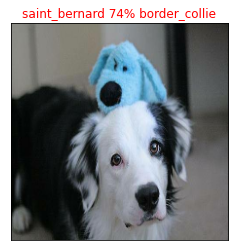

In [0]:
plot_pred(predictions, val_labels, val_images, n=11)

Now we've got one function to visualize our models top predictions, let's make another to view our models top 10 predictions.

This function will:
* Take an input of predictions probabilities array and a ground truth array and an integer
* Find the prediction using get_pred_label()
* Find the top 10:
 * Prediction probabilities indexes
 * Prediction probabilities values
 *Prediction labels
* Plot the top 10 prediction probaility value and labels, coloring the true label green

In [0]:
predictions[0].argsort()

array([115,  18,  22,  46, 118,  33,  56,   5,  92,  36,  63,  91,  11,
        41,  24,  52,  94,  99,  47, 112,   1,  51,  86, 101,  21,   4,
        39,  61,  49,  16,  19,  38,  43,   3,  45,  75,  44,  13,  67,
        71, 104,  88,  10,  53,  30,  82,  72,  84, 107, 108,  55,  34,
        48,  95, 110, 113,  25,  58,  78,  27,  37,  42,  50,  12,  20,
         7,  60,  89,  15,  80,  87,   8,  66,  14,  29,  31, 119, 114,
        54,  85,  69,  32,   9, 111,  97, 105,  74,   0, 117,  96,  28,
        23,  90,  62,   2,  93,  98,  81,  40,  64,  57,   6,  83,  79,
       106, 116,  73, 102, 100,  76,  70,  77,  68,  59,  65, 103, 109,
        35,  26,  17])

In [0]:
predictions[0].argsort()[-10:]

array([ 70,  77,  68,  59,  65, 103, 109,  35,  26,  17])

In [0]:
predictions[0].argsort()[-10:][::-1]

array([ 17,  26,  35, 109, 103,  65,  59,  68,  77,  70])

In [0]:
predictions[0][predictions[0].argsort()[-10:][::-1]]

array([0.21701549, 0.10852735, 0.10764608, 0.10517503, 0.09992141,
       0.07623531, 0.05232634, 0.03932171, 0.03218506, 0.02278879],
      dtype=float32)

In [0]:
predictions[0].max()

0.21701549

In [0]:
np.argmax(predictions[0])

17

In [0]:
def plot_pred_conf(prediction_preobabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidence along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_preobabilities[n], labels[n]

  #Get the prediction label
  pred_label = get_pred_label(pred_prob)

  #Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  #Find the top 10 prediction confidence value
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  #Find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  #Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  #Change colour of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


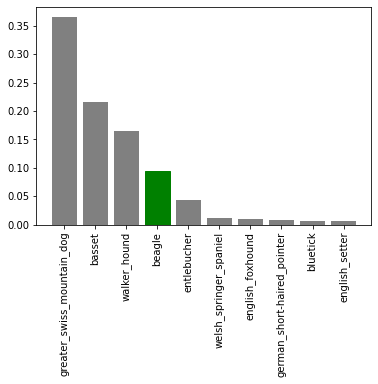

In [0]:
plot_pred_conf(predictions, val_labels, 111)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

In [0]:
# Let's check out a few predictions and their different values
i_multiplier = 4
num_rows = 10
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_preobabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)  
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Challenge:** How could you create a confusion matrix with our models predictions and true labels? 

## Saving and reloading a trained model

In [0]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string)
  """

  #Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Colab Notebooks/Data/dog-vision-data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" #Save format model
  print(f"Saving model to:{model_path}...")
  model.save(model_path)
  return model_path

In [0]:
#Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from :{model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [0]:
#Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to:drive/My Drive/Colab Notebooks/Data/dog-vision-data/models/20200417-02321587090761-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Colab Notebooks/Data/dog-vision-data/models/20200417-02321587090761-1000-images-mobilenetv2-Adam.h5'

In [0]:
#Load a trained model
load_1000_image_model = load_model('drive/My Drive/Colab Notebooks/Data/dog-vision-data/models/20200416-11331587036837-1000-images-mobilenetv2-Adam.h5')

Loading saved model from :drive/My Drive/Colab Notebooks/Data/dog-vision-data/models/20200416-11331587036837-1000-images-mobilenetv2-Adam.h5


In [0]:
# Evaluate the pre-saved model
model.evaluate(valid_data)

7/7 [==============================] - 1s 138ms/step - loss: 1.2376 - accuracy: 0.6850


[1.237598180770874, 0.6850000023841858]

In [0]:
#Evaluate the loaded model
load_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 1s 141ms/step - loss: 1.1708 - accuracy: 0.6900


[1.1708227396011353, 0.6899999976158142]

## Training a big dog model (on the full data)

In [0]:
len(x), len(y)

(10222, 10222)

In [0]:
#Create a data batch with the full data set
full_data = create_data_batches(x,y)

Creating training data batches...


In [0]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [0]:
#Create a model for full model
full_model = create_model()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
#Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
#No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3) 

In [0]:
#Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 7281s 23s/step - loss: 1.3478 - accuracy: 0.6675
Epoch 2/100
320/320 [==============================] - 62s 194ms/step - loss: 0.4010 - accuracy: 0.8786
Epoch 3/100
320/320 [==============================] - 61s 190ms/step - loss: 0.2384 - accuracy: 0.9320
Epoch 4/100
320/320 [==============================] - 61s 190ms/step - loss: 0.1531 - accuracy: 0.9661
Epoch 5/100
320/320 [==============================] - 62s 193ms/step - loss: 0.1068 - accuracy: 0.9790
Epoch 6/100
320/320 [==============================] - 61s 191ms/step - loss: 0.0786 - accuracy: 0.9862
Epoch 7/100
320/320 [==============================] - 62s 193ms/step - loss: 0.0594 - accuracy: 0.9903
Epoch 8/100
320/320 [==============================] - 61s 190ms/step - loss: 0.0471 - accuracy: 0.9931
Epoch 9/100
320/320 [==============================] - 61s 190ms/step - loss: 0.0375 - accuracy: 0.9958
Epoch 10/100
320/320 [==============================] - 61s 192m

In [0]:
#Save our full_model trained on 10222 images
save_model(full_model, suffix="10222-images-mobilenetv2-Adam")

Saving model to:drive/My Drive/Colab Notebooks/Data/dog-vision-data/models/20200417-04521587099161-10222-images-mobilenetv2-Adam.h5...


'drive/My Drive/Colab Notebooks/Data/dog-vision-data/models/20200417-04521587099161-10222-images-mobilenetv2-Adam.h5'

In [0]:
full_model = load_model('drive/My Drive/Colab Notebooks/Data/dog-vision-data/models/20200417-04521587099161-10222-images-mobilenetv2-Adam.h5')

Loading saved model from :drive/My Drive/Colab Notebooks/Data/dog-vision-data/models/20200417-04521587099161-10222-images-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and cover them into Tensor batches.

To make predictions on the test data, we'll:
* Get the images filanames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
*  Make a predictions array by passing the test batches to the `predict()` method called on our model.

**Note** Calling `predict()` on our full model and passing it the test data batches will take a long time to run(about an ~1hr)

In [0]:
#Load test image filenames
test_path = "drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]


['drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/ebe4a8b8507fa28905cb7e70b90b9170.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/e8d5c81029e17c81b06af60ec4113b30.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/f35539d88ab6f98c2e4d8891e1de687c.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/f157256196b2c6e28a739d2947e956e5.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/f51f6aeea8a23b6bd62728fde8f04ad8.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/f14fea2fe647a06dce75eb19dbf1273f.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/f11821f2a5777c36a4081588fb96798f.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/e9fe358382731f9288768526be01c950.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/f1c41fe76fb9962343d34c58efb384cd.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/test/edcbb82f5b90a8010fed3fa25b632fc3.jpg']

In [0]:
#Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [0]:
#Make predictions on test data batches using the loaded full model
test_predictions = full_model.predict(test_data, 
                                             verbose=1)

324/324 [==============================] - 7345s 23s/step


In [0]:
#Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/My Drive/Colab Notebooks/Data/dog-vision-data/preds_array.csv", test_predictions, delimiter=",")

In [0]:
#Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Colab Notebooks/Data/dog-vision-data/preds_array.csv", delimiter=",")

In [0]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking the kaggle sample submission, we find that it wants our models probability outputs in a DataFrame with an ID and a column for each different dog breed. 
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format , we'll:
* Create a pandas Dataframe with an ID column as well as a column for each dog breed.
* Add data to ID column by extracting the test image ID's from their filepaths
* Add data (the predictions probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [0]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [0]:
#Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  ebe4a8b8507fa28905cb7e70b90b9170  ...       4.73398e-12
1  e8d5c81029e17c81b06af60ec4113b30  ...       2.21738e-08
2  f35539d88ab6f98c2e4d8891e1de687c  ...       4.88964e-11
3  f157256196b2c6e28a739d2947e956e5  ...        0.00294876
4  f51f6aeea8a23b6bd62728fde8f04ad8  ...         2.542e-07

[5 rows x 121 columns]

In [0]:
#Save our predictions dataframe to csv for submission to Kaggle
preds_df.to_csv("drive/My Drive/Colab Notebooks/Data/dog-vision-data/full_model_predictions_submission_1_mobilenetV2.csv", index=False)

In [0]:
#Transfer learning Mobile Net v2 dog vision

## Make predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images
* Turn the filepaths into data batches using `create_data_batches()` .And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the predictions output probabilities  to predictions labels.
* Comapre the predicted labels to the custom image.

In [0]:
#Get the custom image filepaths
custom_path = "drive/My Drive/Colab Notebooks/Data/dog-vision-data/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

['drive/My Drive/Colab Notebooks/Data/dog-vision-data/my-dog-photos/German_Shepherd.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/my-dog-photos/Siberian_Husky.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/my-dog-photos/French_Bull_Dog.jpg',
 'drive/My Drive/Colab Notebooks/Data/dog-vision-data/my-dog-photos/Maltese.jpg']

In [0]:
#Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
#Make predictions on the custom data
custom_preds = full_model.predict(custom_data)
len(custom_preds)

4

In [0]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

In [0]:
#Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
#Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

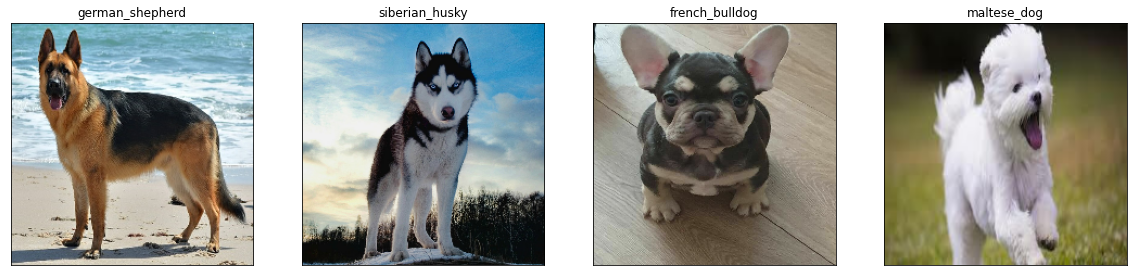

In [0]:
#Check custom image predictions
plt.figure(figsize=(20, 20))
for i, image in enumerate(custom_images):
  plt.subplot(1, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)